In [13]:
pwd

'/data2/mito_lineage/Analysis/peaks_expression/CHIP_april08_2021'

In [14]:
import os
from src.utils.parse_config import read_config_file
import mplh.cluster_help as ch


In [15]:
config_f = "config.yaml"
samples="Control,Flt3l,Input"
outdir=""

In [16]:
if outdir == "":
    outdir="./output"

if not os.path.exists(outdir):
    os.mkdir(outdir)
config = read_config_file(config_f)
chip_genes = config["chip_genes"]

In [17]:
from os.path import join, dirname
import pandas as pd
from glob import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mplh.fig_utils import helper_save as hs
config

{'global': 'PROJECT',
 'indir': '/data2/isshamie/mito_lineage/data/processed/mtscATAC/CHIP_april08_2021_Croker/MTblacklist',
 'experiment': 'CHIP_april08_2021',
 'genome': 'MTblacklist',
 'chip_genes': ['TP53', 'U2AF1', 'SF3B1', 'SRSF2', 'TET2', 'IDH1', 'IDH2'],
 'samples': ['Control', 'Flt3l', 'Input']}

num good cells: 843
peaks_sparse_mtx         0  1  2
1  107868  1  2
2  107737  1  2
3  107289  1  2
4  107018  1  2
5  107001  1  2


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


num good cells: 5313
peaks_sparse_mtx         0  1  2
1  169408  1  2
2  169383  1  2
3  169241  1  2
4  169039  1  2
5  169029  1  4


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


num good cells: 222
peaks_sparse_mtx         0  1  2
1  231899  1  2
2  231849  1  2
3  231839  1  3
4  231814  1  2
5  231778  1  2


/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/isshamie/software/anaconda2/envs/mito_trace/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


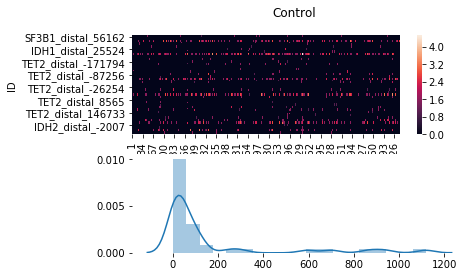

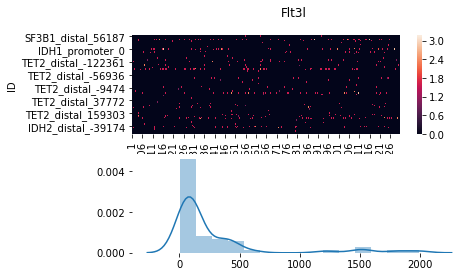

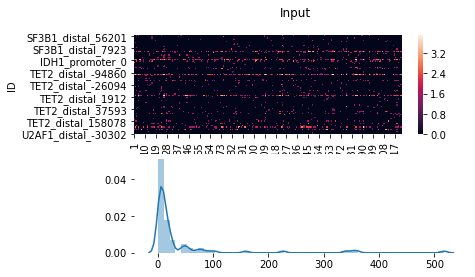

In [18]:
%matplotlib inline

all_chip_df = {}
all_chip_dense = {}
for s in config['samples']:
    curr_in = join(config["indir"], s, 'outs')
    ### Create 1-based cell barcode index 
    cells = pd.read_csv(join(curr_in,"singlecell.csv"))
    cells

    good_cells = cells[~(cells["cell_id"]=="None")].copy()
    good_cells["ID"] = np.arange(1,len(good_cells)+1)
    print('num good cells:', len(good_cells))

    cell_inds = pd.read_csv(join(curr_in, "filtered_peak_bc_matrix","barcodes.tsv"),header=None)

    ## Load peak annotations
    peak_annotations = pd.read_csv(join(config["indir"], s, 'outs','peak_annotation.tsv'),sep='\t')
    peak_annotations.index = peak_annotations.index+1
    
    ### Load clusters
    cluster_f = glob(join(config["indir"], s, 'outs','analysis',"clustering", "graphclust","clusters.csv"))
    clusters_df = pd.read_csv(cluster_f[0])
    clusters_df.index = clusters_df.index+1

    ## Load peaks matrix
    filename = join(config['indir'],s,'outs','filtered_peak_bc_matrix/matrix.mtx')
    peaks_sparse_mtx = pd.read_csv(filename,sep=' ',skiprows=2, header=None).iloc[1:]
    print('peaks_sparse_mtx', peaks_sparse_mtx.head())
    peaks_sparse_mtx.columns = ["Peak", "Cell", "Count"]
    
    peaks_sparse_mtx["Cluster"] = peaks_sparse_mtx["Cell"].map(clusters_df["Cluster"])
    peaks_sparse_mtx["gene"] = peaks_sparse_mtx["Peak"].map(peak_annotations["gene"])
    
    peaks_dense = peaks_sparse_mtx.pivot(index="Peak", columns="Cell",values="Count").fillna(0)
    chip_df = peak_annotations[peak_annotations["gene"].isin(chip_genes)]
    chip_inds = peak_annotations[peak_annotations["gene"].isin(chip_genes)].index
    chip_df["ID"] = chip_df.apply(lambda x: x["gene"]+"_"+x["peak_type"]+"_"+x["distance"],axis=1)
    chip_dist = (pd.merge(peaks_dense, chip_df[["ID"]], 
                  left_index=True, right_index=True).set_index("ID")>0).sum(axis=1)
    chip_peaks_dense = peaks_dense.loc[chip_df.index].copy()
    f = plt.figure()
    plt.subplot(2,1,1)
    sns.heatmap(np.log2(1+pd.merge(peaks_dense, chip_df[["ID"]], 
                  left_index=True, right_index=True).set_index("ID")))
    plt.subplot(2,1,2)
    sns.distplot(pd.merge(peaks_dense, chip_df[["ID"]], left_index=True, right_index=True).set_index("ID").sum(axis=1))
    plt.suptitle(s)
    all_chip_df[s] = chip_df
    all_chip_dense[s] = chip_peaks_dense
    hs(os.path.join(outdir, f"chip_{s}"))

## Merge

In [19]:
from src.mlflow.clones import combine_dfs
from copy import deepcopy
chip_meta = combine_dfs(deepcopy(all_chip_df), use_key=True, key_label="Condition", axis=0)
chip_dense = combine_dfs(deepcopy(all_chip_dense), use_key=True, key_label="Condition", axis=0)

In [20]:
all_chip_df["Control"]

,peak,gene,distance,peak_type,ID
17341,chr2_197378451_197378865,SF3B1,56162,distal,SF3B1_distal_56162
17342,chr2_197425773_197425880,SF3B1,9147,distal,SF3B1_distal_9147
17343,chr2_197434412_197435641,SF3B1,0,promoter,SF3B1_promoter_0
17344,chr2_197442560_197443246,SF3B1,-7470,distal,SF3B1_distal_-7470
17345,chr2_197443765_197444364,SF3B1,-8675,distal,SF3B1_distal_-8675
17739,chr2_208228484_208228798,IDH1,25524,distal,IDH1_distal_25524
17740,chr2_208250394_208250839,IDH1,3483,distal,IDH1_distal_3483
17741,chr2_208252804_208255891,IDH1,0,promoter,IDH1_promoter_0
28816,chr4_104963858_104963885,TET2,-181990,distal,TET2_distal_-181990
28817,chr4_104966560_104967136,TET2,-178739,distal,TET2_distal_-178739


In [21]:
chip_meta

,peak,gene,distance,peak_type,ID,Condition
17341,chr2_197378451_197378865,SF3B1,56162,distal,SF3B1_distal_56162,Control
17342,chr2_197425773_197425880,SF3B1,9147,distal,SF3B1_distal_9147,Control
17343,chr2_197434412_197435641,SF3B1,0,promoter,SF3B1_promoter_0,Control
17344,chr2_197442560_197443246,SF3B1,-7470,distal,SF3B1_distal_-7470,Control
17345,chr2_197443765_197444364,SF3B1,-8675,distal,SF3B1_distal_-8675,Control
...,...,...,...,...,...,...
183377,chr15_90109528_90109832,IDH2,-7025,distal,IDH2_distal_-7025,Input
183378,chr15_90142561_90143807,IDH2,-40058,distal,IDH2_distal_-40058,Input
193839,chr17_7674840_7674910,TP53,583,distal,TP53_distal_583,Input
222304,chr21_43107372_43107687,U2AF1,0,promoter,U2AF1_promoter_0,Input


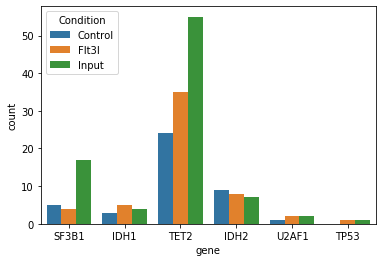

In [22]:
sns.countplot(data=chip_meta, x="gene" , hue="Condition")

In [23]:
chip_meta.groupby("Condition").size()

Condition
Control    42
Flt3l      55
Input      86
dtype: int64

# plot with meta

In [25]:
#rand_df = chip_peaks_dense.sample(n=500,axis=1)
ch.plot_cluster(chip_peaks_dense.fillna(0), row_meta=chip_df[["gene", "peak_type"]], 
                col_meta=samples.drop("Barcode",axis=1), to_row_clust=False, row_names=False,
                metric='jaccard', to_legend=True, white_name=None )

AttributeError: 'str' object has no attribute 'drop'

In [ ]:
#geneType_imm_anno = imm_anno.rename(imm_anno.apply(lambda x: x["gene"]+"_"+x["peak_type"],axis=1), axis=0)
rand_df = chip_peaks_dense.sample(n=min(chip_peaks_dense.shape[1], 1000),axis=1)
ch.plot_cluster(rand_df.fillna(0), row_meta=chip_df[["gene", "peak_type"]], 
                col_meta=samples.drop("Barcode",axis=1).loc[rand_df.columns], to_row_clust=True, 
                metric='jaccard', vmax=1, to_legend=True, white_name=None, row_names=False )

In [ ]:
peaks_dense[x]

In [ ]:
chip_dense

In [ ]:
chip_meta